# COMTE

A counterfactual explanation, originally introduced to machine learning by [2], answers the question "what if" by building counterexamples. Based on an input instance $x$, the goal is to find a counterfactual $x^{cf}$ close to the original instance $x$ but differently classified $y \neq y^{cf}$ by a predictor $f$. The intention is to visualize boundary cases. Further research has shown that counterfactual explanations are easy to understand for humans because they are intuitive  to human thinking by showing counterexamples.  

Counterfactual Explanations for Machine Learning on Multivariate Time Series Data (COMTE) developed by Ates et al. [1] builds counterfactuals in multivariate setting by perturbing the features of a time series with the help of an heuristic algorithm. They adapted the original formualtion of Wachter et al. [2] $L= \lambda (f(x^{cf}-y^{cf}))+d(x,x^{cf})$ by replacing the point wise distance function $d$ with a function on feature basis. 

<img src="https://fzi-forschungszentrum-informatik.github.io/TSInterpret/Notebooks/COMTE.png" alt="Visualization of COMTE" style="width: 800px;"/>

The code in TSInterpret is based on the authors <a href='https://github.com/peaclab/CoMTE'>implementation </a>.

[1] Emre Ates, Burak Aksar, Vitus J. Leung, and Ayse K. Coskun. Counterfactual Explanations for Machine Learning on Multivariate Time Series Data. 2021 International Conference on Applied Artificial Intelligence (ICAPAI), pages 1–8, May 2021. arXiv: 2008.10781. URL: http://arxiv.org/abs/2008.10781 (visited on 2022-03-25), doi:10.1109/ICAPAI49758.2021.9462056.

[2] Wachter, Sandra, Brent Mittelstadt, and Chris Russell. "Counterfactual explanations without opening the black box: Automated decisions and the GDPR." Harv. JL & Tech. 31 (2017): 841.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import torch
import warnings
warnings.filterwarnings("ignore") 

## Load Data 
Load Data and reshape the data to fit a 1D-Conv ResNet. Note that the input for a 1D-Conv Resnet hat the shape (batch, features, timesteps).

In [2]:
dataset='BasicMotions'

In [3]:
X_train,y_train, X_test, y_test=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])
train_y = y_train
test_y=y_test



In [4]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(train_y.reshape(-1,1))
f=open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb')
pickle.dump(enc1,f)
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))



## Model Training / Loading
Trains a ResNet and saves the results.

In [5]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)


In [6]:
model = ResNetBaseline(in_channels= X_train.shape[-1], num_pred_classes=n_pred_classes)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))


<All keys matched successfully>


## Interpretability Algorithm

Using a interpretability algorithm consists of 4 steps:

1. Load the Interpretability Method
2. Instaniate the Method with the desired Parameters
3. Call the explain Method
4. Plot the results

### 1. & 2. Loading & Initialization

COMTE works on all models returning a probability function. The Initialization takes the following arguments:

    `model`: The model to be explaines.
    `data`: Tuple of Data and Labels.
    `backend`: `PYT`, `SK`, or `TF`.
    `mode`: second dimension is either `feat` or `time`. 
    `method`: Optimization Method either `brut` or `opt`.

In [7]:
model.eval()
item=test_x[1].reshape(1,test_x.shape[1],-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
y_pred = torch.nn.functional.softmax(model(_item)).detach().numpy()
y_label= np.argmax(y_pred)


In [8]:
from TSInterpret.InterpretabilityModels.counterfactual.Ates import AtesCF
exp_model= AtesCF(model,(train_x,train_y),backend='PYT',mode='feat', method= 'opt')



### 3. Call the explain method.

Prepeare the instance and the predicted label of the instance as parameters for the explain methods.

- `item`: item to be explained

In [9]:
exp = exp_model.explain(item)


In [10]:
array, label=exp
print(label)

[3]


### 4. Visualization

All plot function take as input the item to be explained and the returned explanation. As as additonal option a figsize can be given.


ITEM (6, 100)
EXP (6, 100)
PLOT MULTU


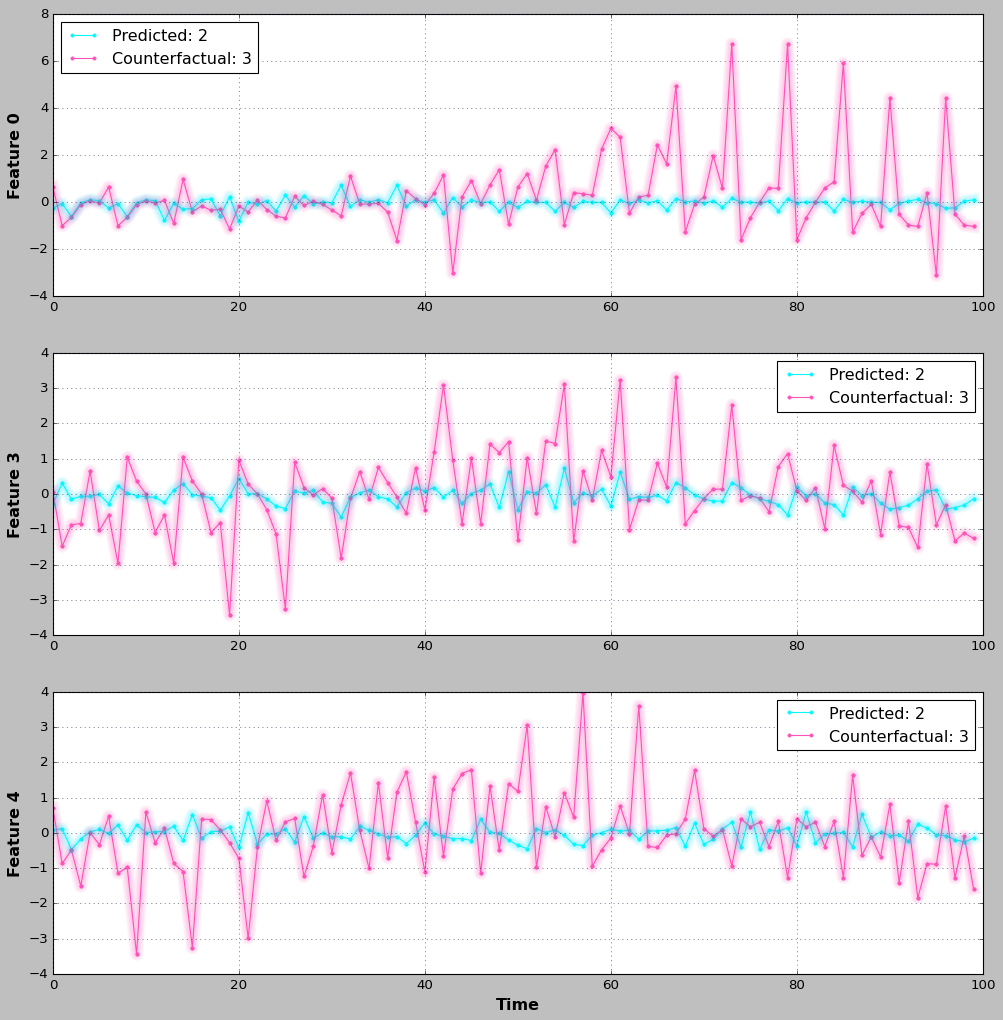

In [11]:
i=0
org_label=y_label
cf_label=label[0]
exp=array

exp_model.plot_in_one(item,org_label,exp,cf_label)

Additional Examples, e.g. for the use with LSTM or TF can be found <a href='https://github.com/JHoelli/TSInterpret/blob/main/docs/Notebooks'>here</a>.